## Molecular representation benchmarks - MolProp250K

**Molecular Properties Datasets**

ZINC is a widely utilized public access database and tool set, playing a crucial role in various applications including virtual screening, ligand discovery, pharmacophore screens, benchmarking, and force field development. The **MolProp250K** dataset consists of 250,000 compounds randomly selected from **ZINC15**.

**Benchmarking goal:** 

The objective is to comprehend the proficiency of a model in predicting these 'easy' properties, gauging its effectiveness. Ideally, any pre-trained models should, at the very least, demonstrate good performance in those tasks before applying them to the downstream tasks. 

**Molecule data resource**: 

https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit
import polaris 
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification
from polaris.utils.types import HubOwner, License

import os
os.chdir("..")

In [3]:
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

In [19]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/molprop"
DATASET_DIR = "gs://polaris-public/Datasets/molprop"

## Load existing data
> **Attention:** \
> The original dataset is published in https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv \
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [01_ZINC15_250K_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/blob/mvp/02_MolProp/01_ZINC15_250K_curation.ipynb)


In [4]:
# Path to the curated data
url = "gs://polaris-public/Data/zinc250k/molecular_properties_2023-07-14.parquet"
table = pd.read_parquet(url)

In [5]:
table.describe()

,mw,fsp3,n_rotatable_bonds,tpsa,clogp,formal_charge,n_charged_atoms,refractivity,n_aromatic_rings
count,249455.000000,249455.000000,249455.000000,249455.000000,249455.000000,249455.000000,249455.000000,249455.000000,249455.000000
mean,331.754739,0.411125,4.560173,64.820972,2.457121,0.202638,0.413209,89.161769,1.849833
std,61.843063,0.220376,1.550658,22.934680,1.434336,0.543069,0.668481,17.147501,0.969474
min,149.975153,0.000000,0.000000,0.000000,-6.876200,-3.000000,0.000000,17.490000,0.000000
25%,290.197537,0.250000,3.000000,49.310000,1.574900,0.000000,0.000000,77.750700,1.000000
50%,333.205242,0.384615,5.000000,64.110000,2.605600,0.000000,0.000000,89.188200,2.000000
75%,368.153621,0.555556,6.000000,79.710000,3.486760,0.000000,1.000000,100.281250,2.000000
max,499.726723,1.000000,11.000000,149.700000,8.252100,4.000000,6.000000,151.271000,6.000000


### Below we specify the meta information of data columns

In [6]:
data_cols = [
        "mw",
        "fsp3",
        "n_rotatable_bonds",
        "tpsa",
        "clogp",
        "formal_charge",
        "n_charged_atoms",
        "refractivity",
        "n_aromatic_rings",
    ]

In [7]:
annotations = {
    "smiles": ColumnAnnotation(
        description="Molecule Smiles string",
        modality="molecule",
    ),
    "mw": ColumnAnnotation(
        description="Molecular weight computed with <datamol.descriptor.mw>"
    ),
    "fsp3": ColumnAnnotation(
        description="Fraction of saturated carbons computed with <datamol.descriptor.fsp3>"
    ),
    "n_rotatable_bonds": ColumnAnnotation(
        description="A rotatable bond is defined as any single non-ring bond, attached to a non-terminal, non-hydrogen atom, computed with <datamol.descriptor.n_rotatable_bonds>"
    ),
    "tpsa": ColumnAnnotation(
        description="Topological polar surface area of a molecule is defined as the surface sum over all polar atoms or molecules, primarily oxygen and nitrogen, also including their attached hydrogen atoms. Computed with <datamol.descriptor.tpsa>"
    ),
    "clogp": ColumnAnnotation(
        description="Wildman-Crippen LogP value, computed with <datamol.descriptor.clogp>"
    ),
    "formal_charge": ColumnAnnotation(
        description="Formal Charge is a charge assigned to an atom under the assumption that all electrons in bonds are shared equally, computed with <datamol.descriptor.formal_charge>"
    ),
    "n_charged_atoms": ColumnAnnotation(
        description="Number of charged atoms in a molecule, computed with <datamol.descriptor.n_charged_atoms>"
    ),
    "refractivity": ColumnAnnotation(
        description="The total polarizability of a mole of a substance and is dependent on the temperature, the index of refraction, and the pressure. Computed with <datamol.descriptor.refeactivity>"
    ),
    "n_aromatic_rings": ColumnAnnotation(
        description="Number of aromatic rings in the molecule, computed with <datamol.descriptor.n_aromatic_rings>"
    ),
}

###  Define the `Dataset` object

In [36]:
dataset_name = "molprop250k_v1"
with open(f"readme/datasets/{dataset_name}_readme.md") as f:
    dataset_readme = f.read()

In [51]:

dataset = Dataset(
    table=table[annotations.keys()],
    name=dataset_name+"_1",
    description=" Molecule properties computed for ZINC15 250K dataset. Those molecular properties are used to examinate the usefullness of any pretrained models. Especially, any model for generation purpose should not fail on these tasks.",
    source="https://polarishub.io/",
    annotations=annotations,
    owner=owner,
    tags=["Representation", "Molecular Properties"],
    readme=dataset_readme
)

In [40]:
# save the dataset
SAVE_DIR = f"gs://polaris-public/Datasets/MolProp/{dataset_name}"
dataset.to_json(SAVE_DIR)

'gs://polaris-public/Datasets/MolProp/molprop250k_v1/dataset.json'

## Create scaffold split for `molProp250K_zinc15` dataset
> **Note:**
> Here we use splitting tool `Splito` to split dataset to train and test. \
> [Splito](https://github.com/datamol-io/splito) is a machine learning dataset splitting library for life sciences.

The objective is to comprehend the proficiency of a model in predicting these 'easy' properties. \
In order to select the predictive models which is able to generalize to new chemical space, a scaffold split is used to generate trian/test sets. 

In [41]:
# scaffold split
from splito._scaffold_split import ScaffoldSplit

TEST_SIZE = 0.2
SEED = 111
splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
scaffold_split = next(splitter.split(X=dataset.table.smiles.values))

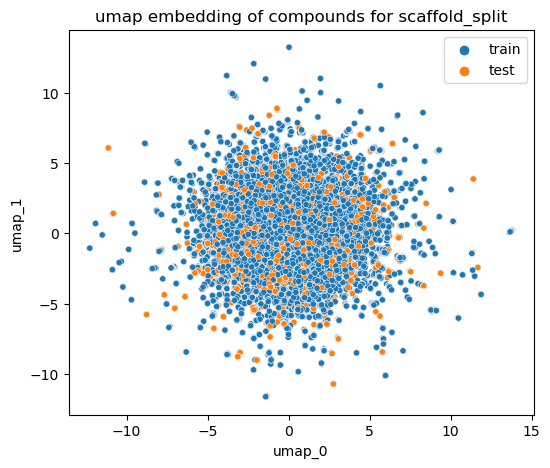

In [42]:
from utils import display_umap
fig = display_umap(data=table, mol_col="smiles", 
                   split=scaffold_split, split_name="scaffold_split",
                  method="umap")
fig.savefig(f"figures/{dataset_name}_umap_scaffold_split.svg")

## Create a Benchmark for MolProp250K dataset
### Multitask for all properties with a shared scaffold split. 

In [43]:
benchmark_version = "v1"
benchmark_name=f"{dataset_name}_multitask_reg_{benchmark_version}"

In [44]:
with open(f"readme/benchmarks/{benchmark_name}_readme.md") as f:
    benchmark_readme = f.read()

In [58]:
benchmark = MultiTaskBenchmarkSpecification(
    name = benchmark_name+"_2", 
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="mean_squared_error",
    metrics=["mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var"],
    tags=["Representation", "Multitask", "Regression"], 
    description='A multitask benchmark to predict nine molecular properties including "mw", "fsp3", "n_rotatable_bonds", "tpsa", "clogp", "formal_charge", "n_charged_atoms",  "refractivity", "n_aromatic_rings" for 250K compounds from ZINC15. "Scaffold-based" splitter was used to define training and test set.',
    owner = owner, readme=benchmark_readme)


#### Save the benchmark

In [ ]:
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark.to_json(BENCHMARK_SAVE_DIR)

In [ ]:
fs = dm.fs.get_mapper(BENCHMARK_DIR).fs
fs.ls(BENCHMARK_DIR)

In [54]:
response = dataset.upload_to_hub(access="public")

2023-10-27 14:37:42.226 | SUCCESS  | polaris.hub.client:upload_dataset:489 - Your dataset has been successfully uploaded to the Hub. View it here: https://polarishub.io/datasets/polaristest/molprop250k_v1_1


In [59]:
response = benchmark.upload_to_hub(access="public", timeout= 300)

2023-10-27 15:08:02.576 | SUCCESS  | polaris.hub.client:upload_benchmark:527 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/polaristest/molprop250k_v1_multitask_reg_v1_2
